# SDND Project 3 - Traffic Sign Recognition Classifier

## 0. Load the Data

In [1]:
import pickle

In [2]:
# -- File paths -- #
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

# -- Load files -- #
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# -- Fitting into array -- #
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## 1. Dataset Summary

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import csv

In [4]:
# -- Number of samples -- #
n_train = len(X_train)   
n_valid = len(X_valid)   
n_test = len(X_test)     

# -- Shape of a traffic sign image -- # 
image_shape = X_train[0].shape        

# -- Number of classes -- #
n_classes = len(set(y_train)) 

# -- Labels & names -- #
sign_name_file = pd.read_csv('signnames.csv')
sign_name = sign_name_file.to_dict(orient='index')
sign_name = {key : val['SignName'] for key, val in sign_name.items()}

# -- Print information -- # 
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
for i in range(len(sign_name)):
    print()
    print(i, "-", sign_name[i])

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

0 - Speed limit (20km/h)

1 - Speed limit (30km/h)

2 - Speed limit (50km/h)

3 - Speed limit (60km/h)

4 - Speed limit (70km/h)

5 - Speed limit (80km/h)

6 - End of speed limit (80km/h)

7 - Speed limit (100km/h)

8 - Speed limit (120km/h)

9 - No passing

10 - No passing for vehicles over 3.5 metric tons

11 - Right-of-way at the next intersection

12 - Priority road

13 - Yield

14 - Stop

15 - No vehicles

16 - Vehicles over 3.5 metric tons prohibited

17 - No entry

18 - General caution

19 - Dangerous curve to the left

20 - Dangerous curve to the right

21 - Double curve

22 - Bumpy road

23 - Slippery road

24 - Road narrows on the right

25 - Road work

26 - Traffic signals

27 - Pedestrians

28 - Children crossing

29 - Bicycles crossing

30 - Beware of ice/snow

31 - Wild animals crossing

32 - End of all speed an

### Exploratory Visualization of Dataset

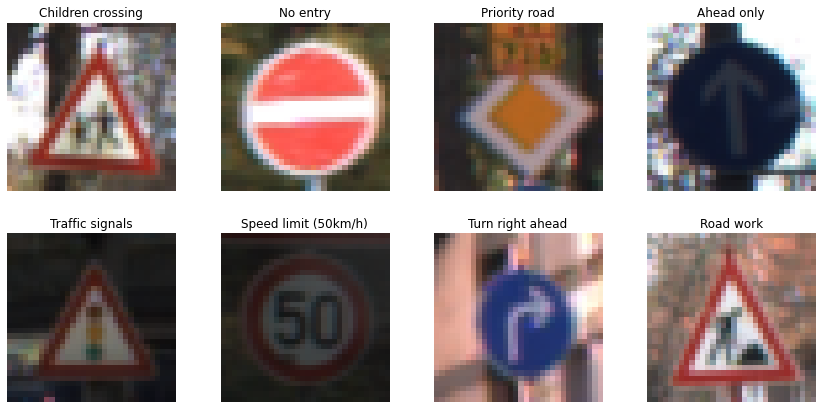

In [10]:
# -- Plot 8 samples in the training set -- #
%matplotlib inline

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.ravel()
fig.tight_layout()

for i in range(8):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    ind = y_train[index]
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title(sign_name[ind])

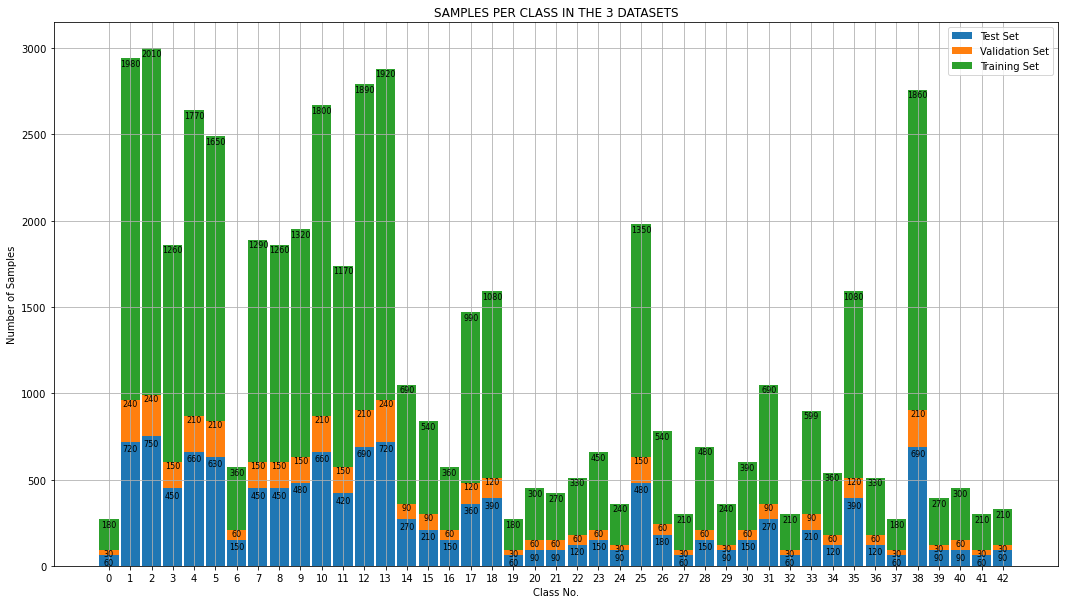

In [6]:
# -- Number of samples per class in 3 datasets -- # 
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_valid, counts_valid = np.unique(y_valid, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# -- Plot sample distribution in the 3 datasets -- # 
x = [unique_train, unique_valid, unique_test]
y = [counts_train, counts_valid, counts_test]
titles = ["TRAINING SET", "VALIDATION SET", "TEST SET"]

width = 0.9
fig, ax = plt.subplots(figsize=(18, 10))

ax.bar(x[2], y[2], width, label='Test Set')
for i, v in enumerate(y[2]):
    ax.text(i, v-40, str(v), color='black', ha='center', va='center', fontsize=8)

ax.bar(x[1], y[1], width, bottom=y[2], label='Validation Set')
for i, v in enumerate(y[1]):
    ax.text(i, v+y[2][i]-20, str(v), color='black', ha='center', va='center', fontsize=8)

ax.bar(x[0], y[0], width, bottom=y[2]+y[1], label='Training Set')
for i, v in enumerate(y[0]):
    ax.text(i, v+y[2][i]+y[1][i]-30, str(v), color='black', ha='center', va='center', fontsize=8)

ax.grid()
ax.set_xticks(x[0])
ax.set_xlabel('Class No.')
ax.set_ylabel('Number of Samples')
ax.legend()
ax.set_title("SAMPLES PER CLASS IN THE 3 DATASETS");

---
## 2. Model Architecture

### 2.1. Data pre-processing

In [12]:
from sklearn.utils import shuffle
import tensorflow as tf
import random

In [13]:
# -- Data augmentation -- # 
def Augment_Images(X, y):
    
    augmented = []
    for i in range(len(X)):
        
        seed = (i, 0)
        image = tf.cast(X[i], tf.float32)
        image = (image / 255.0)
        
        flag = random.randint(0, 9)
        
        if (flag <= 5):
            result = (image * 255)
            augmented.append(result)
            
        if (flag == 6):
            flip_h = tf.image.flip_left_right(image)
            result = (flip_h * 255)
            augmented.append(result)
            
        if (flag == 7):
            flip_v = tf.image.flip_up_down(image)
            result = (flip_v * 255)
            augmented.append(result)
            
        if (flag == 8):
            bright = tf.image.stateless_random_brightness(image, 0.1, seed)
            result = (bright * 255)
            augmented.append(result)
            
        if (flag == 9):
            contrast = tf.image.stateless_random_contrast(image, 0.9, 1.1, seed)
            result = (contrast * 255)
            augmented.append(result)
            
    augmented_nm, y = Preprocess_Images(augmented, y)
        
    return augmented_nm, y

# -- Normalization & grayscaling -- #
def Preprocess_Images(X, y):
    
    normalized = []
    for i in range(len(X)):
        
        image = tf.cast(X[i], tf.float32)
        image = tf.image.rgb_to_grayscale(image)
        image = (image - 128.0) / 128.0
    
        normalized.append(image)
    
    return normalized, y

In [14]:
print("[1-0] Preprocessing Start!")

# -- 1. Shuffle the datasets. -- # 
X_train_sf, y_train_sf = shuffle(X_train, y_train)
X_valid_sf, y_valid_sf = shuffle(X_valid, y_valid)
X_test_sf, y_test_sf = shuffle(X_test, y_test)
print("[1-1] Shuffle Done!")

# -- 2. Data augmentation & normalization. -- #
X_train_pp, y_train_pp = Augment_Images(X_train_sf, y_train_sf)
print("[1-2] Training Data Augmented!")

# -- 3. Normalize & grayscale validation & test sets. -- # 
X_train_nm, y_train_nm = Preprocess_Images(X_train_sf, y_train_sf)
X_valid_nm, y_valid_nm = Preprocess_Images(X_valid_sf, y_valid_sf)
X_test_nm, y_test_nm = Preprocess_Images(X_test_sf, y_test_sf)
print("[1-3] Datasets Normalized & Grayscaled!")

print("[1-F] Preprocessing Done!")

[1-0] Preprocessing Start!
[1-1] Shuffle Done!
[1-2] Training Data Augmented!
[1-3] Datasets Normalized & Grayscaled!
[1-F] Preprocessing Done!


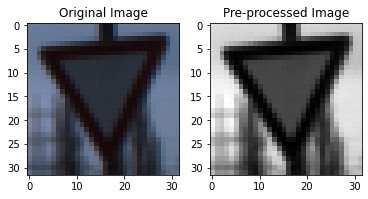

In [20]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train_sf[0])
ax[0].set_title("Original Image")
ax[1].imshow(X_train_pp[0], cmap='gray')
ax[1].set_title("Pre-processed Image");

### 2.2. LeNet-5

In [22]:
import tensorflow.compat.v1 as v1

In [23]:
channels = X_train_pp[0].shape[2]

def LeNet5(X):
    
    # - Random W & b. - # 
    mu = 0
    sigma = 0.1
    epsilon = 0.001
    
    # - L1: Conv. Input: 32x32x3. Output: 28x28x6. - #
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, channels, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.add(tf.nn.conv2d(X, conv1_W, strides=[1, 1, 1, 1], padding='VALID'), conv1_b)
    conv1   = tf.nn.relu(conv1)
    # -- L1 Batch normalization. 
    mean_1, var_1 = v1.nn.moments(conv1, [0])
    scale_1 = tf.Variable(tf.ones([28, 28, 6]))
    offset_1 = tf.Variable(tf.zeros([28, 28, 6]))
    conv1 = v1.nn.batch_normalization(conv1, mean_1, var_1, offset_1, scale_1, epsilon)
    # -- L1 Pooling. Input: 28x28x6. Output: 14x14x6. 
    conv1   = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # - L2: Conv. Input: 14x14x6. Output: 10x10x16. - # 
    conv2_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.add(tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID'), conv2_b)
    conv2   = tf.nn.relu(conv2)
    # -- L2 Batch normalization. 
    mean_2, var_2 = v1.nn.moments(conv2, [0])
    scale_2 = tf.Variable(tf.ones([10, 10, 16]))
    offset_2 = tf.Variable(tf.zeros([10, 10, 16]))
    conv2 = v1.nn.batch_normalization(conv2, mean_2, var_2, offset_2, scale_2, epsilon)
    # -- L2 Pooling. Input: 10x10x16. Output: 5x5x16. 
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # -- L2 Flatten. Input: 5x5x16. Output: 400.
    fc0     = v1.layers.flatten(conv2)   
    
    # - L3: Fully connected. Input: 400. Output: 120. - #
    fc1_W   = tf.Variable(tf.random.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b   = tf.Variable(tf.zeros(120))
    fc1     = tf.add(tf.matmul(fc0, fc1_W), fc1_b)
    fc1     = tf.nn.relu(fc1)
    # -- L3. Batch normalization. 
    mean_3, var_3 = v1.nn.moments(fc1, [0])
    scale_3 = tf.Variable(tf.ones([120]))
    offset_3 = tf.Variable(tf.zeros([120]))
    fc1 = v1.nn.batch_normalization(fc1, mean_3, var_3, offset_3, scale_3, epsilon)
    # -- L3. Dropout. 
    fc1     = v1.nn.dropout(fc1, keep_prob)
    
    # - L4: Fully connected. Input: 120. Output: 84. - #
    fc2_W   = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b   = tf.Variable(tf.zeros(84))
    fc2     = tf.add(tf.matmul(fc1, fc2_W), fc2_b)
    fc2     = tf.nn.relu(fc2)
    # -- L4. Batch normalization. 
    mean_4, var_4 = v1.nn.moments(fc2, [0])
    scale_4 = tf.Variable(tf.ones([84]))
    offset_4 = tf.Variable(tf.zeros([84]))
    fc2 = v1.nn.batch_normalization(fc2, mean_4, var_4, offset_4, scale_4, epsilon)
    # -- L4. Dropout. 
    fc2     = v1.nn.dropout(fc2, keep_prob)
    
    # - L5: Fully connected. Input: 84. Output: 43. - # 
    fc3_W   = tf.Variable(tf.random.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b   = tf.Variable(tf.zeros(43))
    fc3     = tf.add(tf.matmul(fc2, fc3_W), fc3_b)
    logits  = fc3
    
    return logits

### 2.3. Pipeline

In [24]:
EPOCHS = 50
BATCH_SIZE = 128
ETA = 0.01

In [26]:
G = v1.Graph()

with G.as_default():
    
    x = v1.placeholder(tf.float32, (None, 32, 32, channels))
    y = v1.placeholder(tf.int32, (None))
    one_hot_y = v1.one_hot(y, 43)
    keep_prob = v1.placeholder(v1.float32)
    
    logits = LeNet5(x)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = v1.train.AdamOptimizer(learning_rate = ETA, beta1=0.95, beta2=0.98)
    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = v1.train.Saver()
    
    def Evaluate_Model(X_data, y_data):
        
        num_examples = len(X_data)
        total_accuracy = 0
        sess = v1.get_default_session()
        
        for offset in range(0, num_examples, BATCH_SIZE):
            
            batch_x, batch_y = X_data[offset : offset+BATCH_SIZE], y_data[offset : offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
            total_accuracy += (accuracy * len(batch_x))
            
        return total_accuracy / num_examples

In [30]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    num_examples = len(X_train_pp)
    
    print("Training...")
    print()
    v1.set_random_seed(123456)
    for i in range(EPOCHS):
        
        X_train, y_train = shuffle(X_train_pp, y_train_pp)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = Evaluate_Model(X_valid_nm, y_valid_nm)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.821

EPOCH 2 ...
Validation Accuracy = 0.895

EPOCH 3 ...
Validation Accuracy = 0.897

EPOCH 4 ...
Validation Accuracy = 0.920

EPOCH 5 ...
Validation Accuracy = 0.914

EPOCH 6 ...
Validation Accuracy = 0.922

EPOCH 7 ...
Validation Accuracy = 0.917

EPOCH 8 ...
Validation Accuracy = 0.927

EPOCH 9 ...
Validation Accuracy = 0.929

EPOCH 10 ...
Validation Accuracy = 0.921

EPOCH 11 ...
Validation Accuracy = 0.926

EPOCH 12 ...
Validation Accuracy = 0.929

EPOCH 13 ...
Validation Accuracy = 0.940

EPOCH 14 ...
Validation Accuracy = 0.920

EPOCH 15 ...
Validation Accuracy = 0.933

EPOCH 16 ...
Validation Accuracy = 0.938

EPOCH 17 ...
Validation Accuracy = 0.948

EPOCH 18 ...
Validation Accuracy = 0.932

EPOCH 19 ...
Validation Accuracy = 0.928

EPOCH 20 ...
Validation Accuracy = 0.926

EPOCH 21 ...
Validation Accuracy = 0.938

EPOCH 22 ...
Validation Accuracy = 0.929

EPOCH 23 ...
Validation Accuracy = 0.938

EPOCH 24 ...
Validation Accura

In [31]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    train_accuracy = Evaluate_Model(X_train_nm, y_train_nm)
    
    print("Training Accuracy = {:.3f}".format(train_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Training Accuracy = 0.993


In [32]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    valid_accuracy = Evaluate_Model(X_valid_nm, y_valid_nm)
    
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Validation Accuracy = 0.945


In [33]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = Evaluate_Model(X_test_nm, y_test_nm)
    
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.925


---
## 3. Test Model on New Images

### 3.1. Load and plot the images

In [34]:
import matplotlib.image as mpimg
import cv2 
import glob

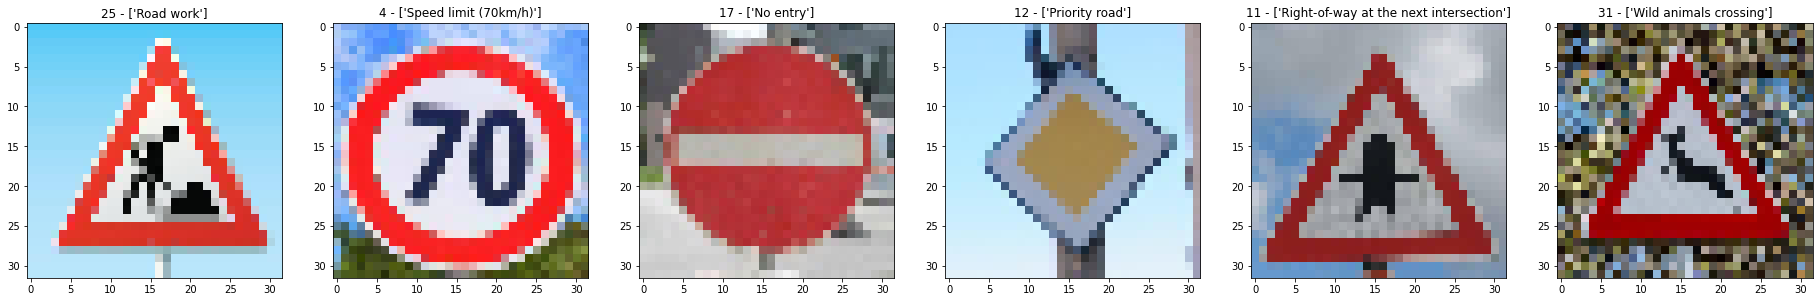

In [35]:
# -- Plot 6 images downloaded from the web -- # 
images = []
for img in glob.glob("test-images/*.jpg"):
    
    image = mpimg.imread(img)
    image = cv2.resize(image, (32, 32))
    images.append(image)
    
y_webimg = [25, 4, 17, 12, 11, 31]
X_webimg, y_webimg = Preprocess_Images(images, y_webimg)

size = image_shape[0]
fig = plt.figure(figsize=(size,size))

for i in range(0, len(images)):
    
    ax = fig.add_subplot(1, len(images), i+1)
    ax.set_title(('{} - {}').format(y_webimg[i],[sign_name[y_webimg[i]]]))
    plt.imshow(images[i])
    
plt.show()

### 3.2. Predict the sign type for each image

In [36]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: X_webimg, y: y_webimg, keep_prob: 1})
    
for i in range(len(predictions)):  
    
    print('Predicted:')
    print('{} : {}'.format(predictions[i], sign_name[predictions[i]]))
    print('Actual:')
    print('{} : {}'.format(y_webimg[i], sign_name[y_webimg[i]]))
    print()

INFO:tensorflow:Restoring parameters from .\lenet
Predicted:
25 : Road work
Actual:
25 : Road work

Predicted:
4 : Speed limit (70km/h)
Actual:
4 : Speed limit (70km/h)

Predicted:
17 : No entry
Actual:
17 : No entry

Predicted:
12 : Priority road
Actual:
12 : Priority road

Predicted:
11 : Right-of-way at the next intersection
Actual:
11 : Right-of-way at the next intersection

Predicted:
31 : Wild animals crossing
Actual:
31 : Wild animals crossing



In [37]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    webimg_accuracy = Evaluate_Model(X_webimg, y_webimg)
    
    print("Test Accuracy on Web Images = {:.3f}".format(webimg_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy on Web Images = 1.000


### 3.3. 5 Top Softmax probabilities for each image

In [38]:
with v1.Session(graph=G) as sess:
    
    sess.run(v1.global_variables_initializer())
    
    k_size = 5
    softmax_logits = tf.nn.softmax(logits)
    top_k = tf.nn.top_k(softmax_logits, k=k_size)

    saver.restore(sess, tf.train.latest_checkpoint('.'))
    image_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_webimg, keep_prob: 1})
    images_top_k = sess.run(top_k, feed_dict={x: X_webimg, keep_prob: 1})
    
for i in range(len(images_top_k[0])):
    
    print()
    print('Image:', i+1, ' Label:', y_webimg[i])
    print('Probabilities:')
    for j in range(0, len(images_top_k[0][i])):
        probabilities = images_top_k[0][i][j]
        index = images_top_k[1][i][j]
        name = sign_name[index]
        print('   {:.6f} : {} - {}'.format(probabilities, index, name))

INFO:tensorflow:Restoring parameters from .\lenet

Image: 1  Label: 25
Probabilities:
   0.999926 : 25 - Road work
   0.000041 : 1 - Speed limit (30km/h)
   0.000030 : 24 - Road narrows on the right
   0.000001 : 27 - Pedestrians
   0.000001 : 2 - Speed limit (50km/h)

Image: 2  Label: 4
Probabilities:
   0.983205 : 4 - Speed limit (70km/h)
   0.005348 : 5 - Speed limit (80km/h)
   0.004728 : 15 - No vehicles
   0.003943 : 3 - Speed limit (60km/h)
   0.001539 : 1 - Speed limit (30km/h)

Image: 3  Label: 17
Probabilities:
   1.000000 : 17 - No entry
   0.000000 : 9 - No passing
   0.000000 : 34 - Turn left ahead
   0.000000 : 14 - Stop
   0.000000 : 33 - Turn right ahead

Image: 4  Label: 12
Probabilities:
   0.998089 : 12 - Priority road
   0.001846 : 9 - No passing
   0.000058 : 35 - Ahead only
   0.000005 : 40 - Roundabout mandatory
   0.000001 : 10 - No passing for vehicles over 3.5 metric tons

Image: 5  Label: 11
Probabilities:
   0.999543 : 11 - Right-of-way at the next intersect